## Dataset Setup (UTKFace)

This notebook uses the [UTKFace dataset](https://susanqq.github.io/UTKFace/).

Please download the dataset manually from one of the sources (e.g., official site, Kaggle mirrors), then extract it into a folder named `gender_age_dataset` in the same directory as this notebook.


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import json
import timm

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
class AgeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [ ]:
# Extract age from filename
def extract_age_labels_from_filename(filename):
    parts = filename.split('_')
    age = int(parts[0])
    return age

# Function to load dataset
def load_age_dataset(dataset_dir):
    images = []
    labels = []

    for subdir in os.listdir(dataset_dir):
        subdir_path = os.path.join(dataset_dir, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith(".jpg"):
                    age = extract_age_labels_from_filename(filename)
                    if age is None:
                        continue
                    image_path = os.path.join(subdir_path, filename)
                    images.append(image_path)
                    labels.append(age)

    return images, labels

In [ ]:
dataset_dir = './gender_age_dataset'
images, labels = load_age_dataset(dataset_dir)

# Split dataset into train, validation, and test
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:
# Data transformation (normalization and resizing)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=45),     # Randomly rotate the image within 45 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained mean and std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained mean and std
])

In [ ]:
# Create datasets and dataloaders
train_dataset = AgeDataset(train_images, train_labels, transform=train_transform)
val_dataset = AgeDataset(val_images, val_labels, transform=train_transform)
test_dataset = AgeDataset(test_images, test_labels, transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

Training samples: 14463, Validation samples: 4821, Test samples: 4822


In [ ]:
batch , label = train_dataset[0]
batch.shape

torch.Size([3, 224, 224])

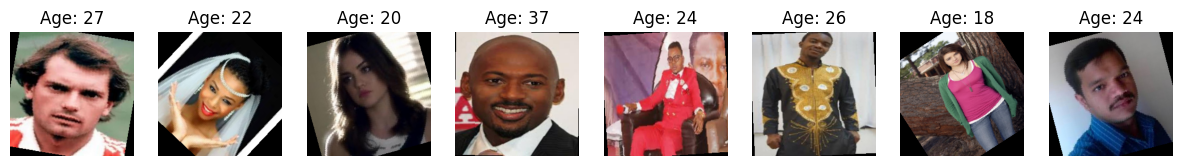

In [ ]:
# Visualize images
def show_age_images(loader, num_images=8):
    images, labels = next(iter(loader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.clamp(0, 1)  # Clamp to valid range
        axes[i].imshow(image)
        axes[i].set_title(f"Age: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

show_age_images(train_loader)


In [ ]:
weights = torchvision.models.VGG19_Weights.DEFAULT
model = torchvision.models.vgg19( weights=weights)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.5MB/s]


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 True
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] 1,792              True
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] 36,928             True
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] 73,856             True
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 11

In [ ]:
# Freeze all parameters in the feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze only the last 12 layers of the feature layers
for param in model.features[-12:].parameters():
    param.requires_grad = True



In [ ]:
model.classifier = nn.Sequential(
    # First block 
    nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Dropout(0.5),  
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU()
    ),

    # Second block 
    nn.Sequential(
        nn.Linear(4096, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.4),  
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        
    ),

    # Third block 
    nn.Sequential(
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        
    ),

    # Fourth block 
    nn.Sequential(
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2),  
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        
    ),

    # Fifth block 
    nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.1),  
        nn.Linear(256, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        
    ),

    # Final layer
    nn.Linear(256, 1)
).to(device)

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 1]            --                 Partial
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)           False
│    └─ReLU (6)                          [32, 128, 112, 112] [32

In [ ]:
# Loss and optimizer
loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=True
)


In [ ]:
# Define the MAE function
def compute_mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))


# Gradient clipping function
def clip_gradient(optimizer, grad_clip=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


In [ ]:
# Initialize lists for tracking metrics
train_losses = []
val_losses = []
train_maes = []
val_maes = []

num_epochs = 15
best_val_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0
best_model_path = 'age_model.pth'
metrics_path = 'age_training_metrics.json'


for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            y_logits = model(inputs).squeeze()
            loss = loss_fn(y_logits, labels)  # Use MSELoss as loss function

            loss.backward()
            clip_gradient(optimizer)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_mae = running_mae / len(train_dataset)

    print(f'Training - Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            y_logits = model(inputs).squeeze()
            loss = loss_fn(y_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_mae = val_running_mae / len(val_dataset)

    print(f'Validation - Loss: {val_loss:.4f} MAE: {val_mae:.4f}')

    # Save the metrics to a file after each epoch
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    train_maes.append(epoch_mae)
    val_maes.append(val_mae)

    with open(metrics_path, 'w') as f:
        json.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_maes': train_maes,
            'val_maes': val_maes
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)  # Adjust learning rate based on validation loss

    # Early stopping and model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Training completed')



Epoch 1/15
----------
Training - Loss: 1186.2695 MAE: 29.8429
Validation - Loss: 1011.8387 MAE: 27.2057
Saved best model with validation loss: 1011.8387

Epoch 2/15
----------
Training - Loss: 787.6697 MAE: 23.7666
Validation - Loss: 531.7189 MAE: 18.8593
Saved best model with validation loss: 531.7189

Epoch 3/15
----------
Training - Loss: 430.3177 MAE: 16.7164
Validation - Loss: 254.0150 MAE: 12.3669
Saved best model with validation loss: 254.0150

Epoch 4/15
----------
Training - Loss: 209.6300 MAE: 10.9631
Validation - Loss: 187.4571 MAE: 9.9275
Saved best model with validation loss: 187.4571

Epoch 5/15
----------
Training - Loss: 143.7567 MAE: 8.7542
Validation - Loss: 131.8226 MAE: 8.2271
Saved best model with validation loss: 131.8226

Epoch 6/15
----------
Training - Loss: 128.7679 MAE: 8.2689
Validation - Loss: 113.6399 MAE: 7.5973
Saved best model with validation loss: 113.6399

Epoch 7/15
----------
Training - Loss: 119.4841 MAE: 7.9610
Validation - Loss: 119.7176 MAE: 7.

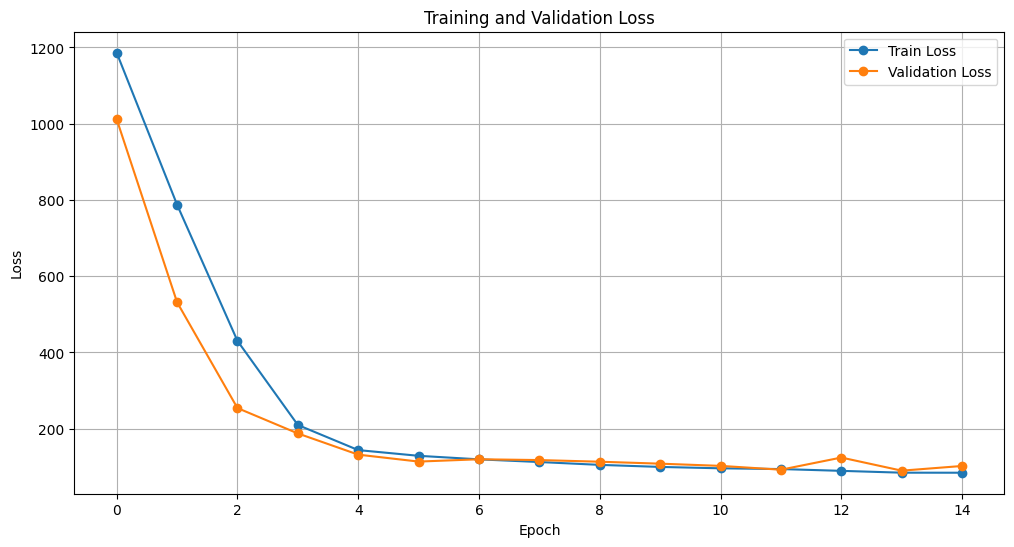

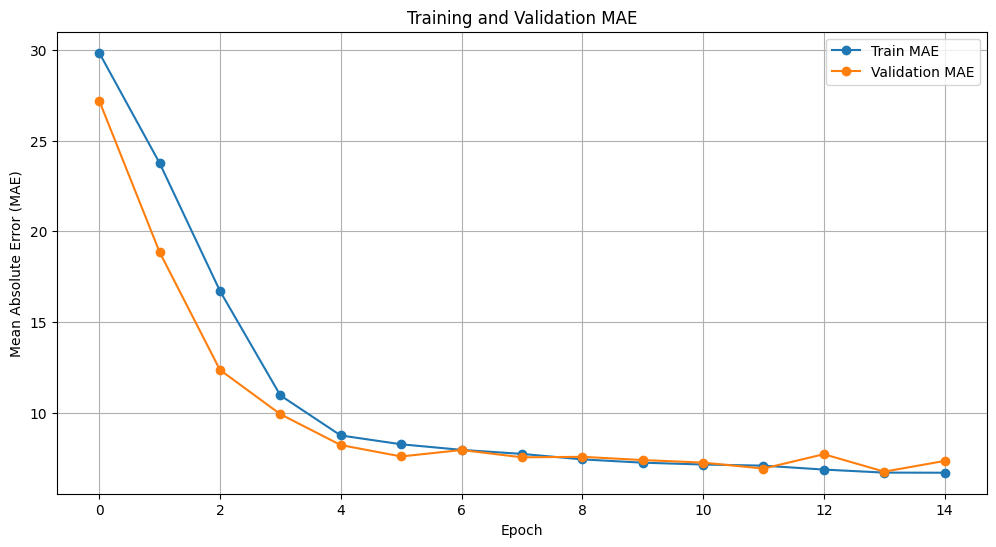

In [ ]:
# Load metrics from the JSON file
metrics_path = './age_training_metrics.json'
with open(metrics_path, 'r') as f:
    metrics = json.load(f)

# Extract the metrics
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_maes = metrics['train_maes']
val_maes = metrics['val_maes']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
plt.plot(train_maes, label='Train MAE', marker='o')
plt.plot(val_maes, label='Validation MAE', marker='o')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
model.eval()
test_running_loss = 0.0
test_running_mae = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        y_logits = model(inputs).squeeze()
        loss = loss_fn(y_logits, labels)

        test_running_loss += loss.item() * inputs.size(0)
        test_running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

test_loss = test_running_loss / len(test_dataset)
test_mae = test_running_mae / len(test_dataset)

print(f'Test - Loss: {test_loss:.4f} MAE: {test_mae:.4f}')

Test - Loss: 94.7603 MAE: 6.9761


In [ ]:
# Unfreeze only the last 20 layers of the feature layers for fine tune
for param in model.features[-20:].parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr=1e-5)
fine_tune_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    fine_tune_optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-7, verbose=True
)

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 1]            --                 Partial
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)           False
│    └─ReLU (6)                          [32, 128, 112, 112] [32

In [ ]:
# Initialize lists for tracking metrics for fine-tuning
fine_tune_train_losses = []
fine_tune_val_losses = []
fine_tune_train_maes = []
fine_tune_val_maes = []

fine_tune_num_epochs = 10
fine_tune_best_val_loss = float('inf')
fine_tune_early_stopping_patience = 5
fine_tune_epochs_without_improvement = 0
fine_tune_best_model_path = 'fine_tuned_age_model.pth'
fine_tune_metrics_path = 'fine_tune_age_training_metrics.json'

for epoch in range(fine_tune_num_epochs):
    print(f'\nFine-Tune Epoch {epoch + 1}/{fine_tune_num_epochs}')
    print('-' * 10)

    # Fine-tuning Training phase
    model.train()
    fine_tune_running_loss = 0.0
    fine_tune_running_mae = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        fine_tune_optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            y_logits = model(inputs).squeeze()
            loss = loss_fn(y_logits, labels)  # Use MSELoss as the loss function

            loss.backward()
            clip_gradient(fine_tune_optimizer)  # Gradient clipping
            fine_tune_optimizer.step()

            fine_tune_running_loss += loss.item() * inputs.size(0)
            fine_tune_running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

    fine_tune_epoch_loss = fine_tune_running_loss / len(train_dataset)
    fine_tune_epoch_mae = fine_tune_running_mae / len(train_dataset)

    print(f'Training - Loss: {fine_tune_epoch_loss:.4f} MAE: {fine_tune_epoch_mae:.4f}')

    # Fine-tuning Validation phase
    model.eval()
    fine_tune_val_running_loss = 0.0
    fine_tune_val_running_mae = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            y_logits = model(inputs).squeeze()
            loss = loss_fn(y_logits, labels)

            fine_tune_val_running_loss += loss.item() * inputs.size(0)
            fine_tune_val_running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

    fine_tune_val_loss = fine_tune_val_running_loss / len(val_dataset)
    fine_tune_val_mae = fine_tune_val_running_mae / len(val_dataset)

    print(f'Validation - Loss: {fine_tune_val_loss:.4f} MAE: {fine_tune_val_mae:.4f}')

    # Save the metrics to a file after each epoch
    fine_tune_train_losses.append(fine_tune_epoch_loss)
    fine_tune_val_losses.append(fine_tune_val_loss)
    fine_tune_train_maes.append(fine_tune_epoch_mae)
    fine_tune_val_maes.append(fine_tune_val_mae)

    with open(fine_tune_metrics_path, 'w') as f:
        json.dump({
            'train_losses': fine_tune_train_losses,
            'val_losses': fine_tune_val_losses,
            'train_maes': fine_tune_train_maes,
            'val_maes': fine_tune_val_maes
        }, f)

    # Learning rate scheduling
    fine_tune_scheduler.step(fine_tune_val_loss)  # Adjust learning rate based on validation loss

    # Early stopping and model checkpoint
    if fine_tune_val_loss < fine_tune_best_val_loss:
        fine_tune_best_val_loss = fine_tune_val_loss
        fine_tune_epochs_without_improvement = 0
        torch.save(model.state_dict(), fine_tune_best_model_path)
        print(f'Saved best model with validation loss: {fine_tune_val_loss:.4f}')
    else:
        fine_tune_epochs_without_improvement += 1

    if fine_tune_epochs_without_improvement >= fine_tune_early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Fine-tuning completed')



Fine-Tune Epoch 1/10
----------
Training - Loss: 74.1688 MAE: 6.2691
Validation - Loss: 88.7554 MAE: 6.5278
Saved best model with validation loss: 88.7554

Fine-Tune Epoch 2/10
----------
Training - Loss: 67.7124 MAE: 6.0462
Validation - Loss: 102.8527 MAE: 7.0115

Fine-Tune Epoch 3/10
----------
Training - Loss: 65.7442 MAE: 5.9507
Validation - Loss: 84.2981 MAE: 6.3905
Saved best model with validation loss: 84.2981

Fine-Tune Epoch 4/10
----------
Training - Loss: 64.4572 MAE: 5.8887
Validation - Loss: 83.7230 MAE: 6.5114
Saved best model with validation loss: 83.7230

Fine-Tune Epoch 5/10
----------
Training - Loss: 63.6729 MAE: 5.8724
Validation - Loss: 89.8969 MAE: 6.6096

Fine-Tune Epoch 6/10
----------
Training - Loss: 60.9414 MAE: 5.7582
Validation - Loss: 79.1969 MAE: 6.4115
Saved best model with validation loss: 79.1969

Fine-Tune Epoch 7/10
----------
Training - Loss: 58.4112 MAE: 5.6809
Validation - Loss: 82.7110 MAE: 6.3486

Fine-Tune Epoch 8/10
----------
Training - Loss

In [ ]:
model.eval()
fine_tune_test_running_loss = 0.0
fine_tune_test_running_mae = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        y_logits = model(inputs).squeeze()
        loss = loss_fn(y_logits, labels)

        fine_tune_test_running_loss += loss.item() * inputs.size(0)
        fine_tune_test_running_mae += compute_mae(y_logits, labels).item() * inputs.size(0)

fine_tune_test_loss = fine_tune_test_running_loss / len(test_dataset)
fine_tune_test_mae = fine_tune_test_running_mae / len(test_dataset)

print(f'Fine tune Test - Loss: {fine_tune_test_loss:.4f} MAE: {fine_tune_test_mae:.4f}')

Fine tune Test - Loss: 88.9491 MAE: 6.5037


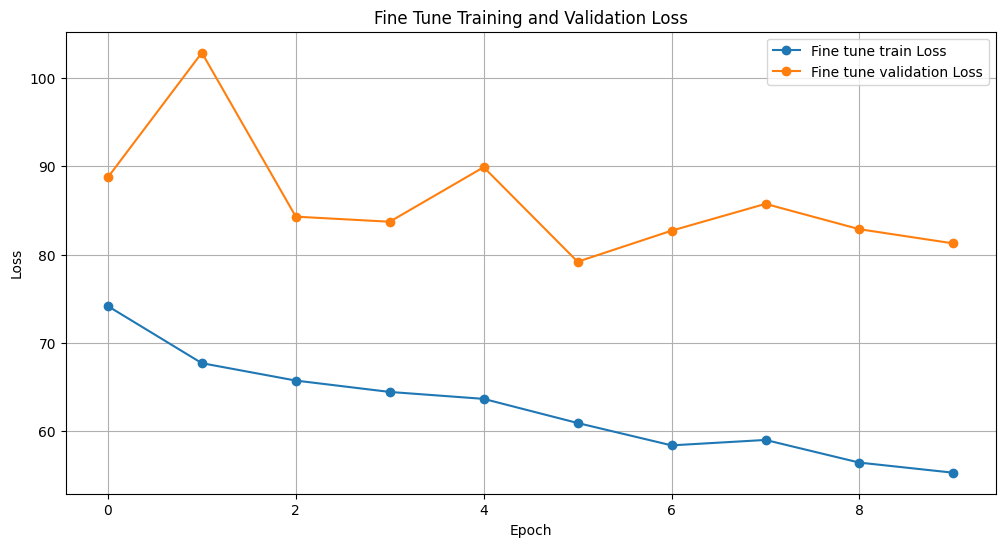

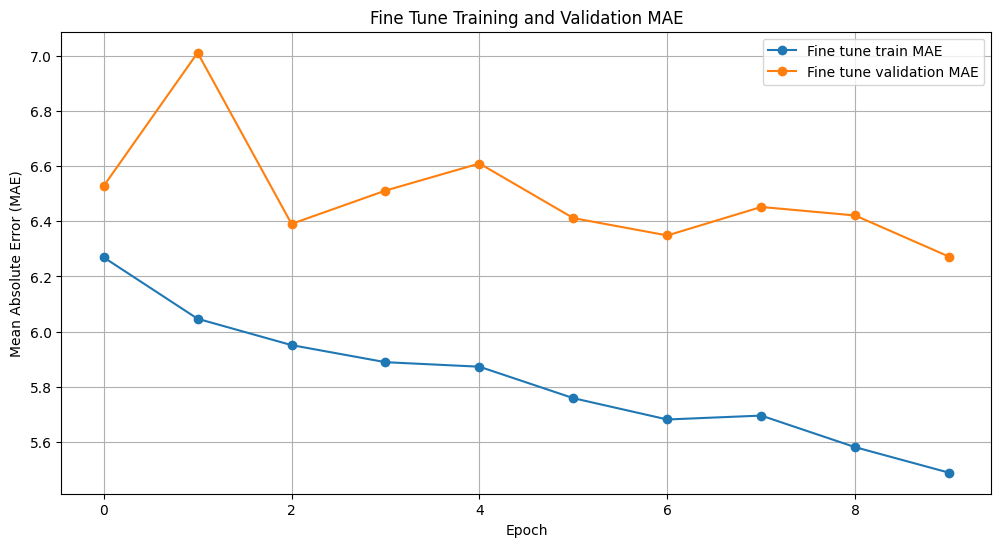

In [ ]:
# Load metrics from the JSON file
fine_tune_metrics_path = './fine_tune_age_training_metrics.json'
with open(fine_tune_metrics_path, 'r') as f:
    fine_tune_metrics = json.load(f)

# Extract the metrics
fine_tune_train_losses = fine_tune_metrics['train_losses']
fine_tune_val_losses = fine_tune_metrics['val_losses']
fine_tune_train_maes = fine_tune_metrics['train_maes']
fine_tune_val_maes = fine_tune_metrics['val_maes']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(fine_tune_train_losses, label='Fine tune train Loss', marker='o')
plt.plot(fine_tune_val_losses, label='Fine tune validation Loss', marker='o')
plt.title('Fine Tune Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
plt.plot(fine_tune_train_maes, label='Fine tune train MAE', marker='o')
plt.plot(fine_tune_val_maes, label='Fine tune validation MAE', marker='o')
plt.title('Fine Tune Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid()
plt.show()
